Connect to drive to access the datasets

In [1]:
# ⬅️ Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# !unzip /content/drive/MyDrive/VLM_project/dataset.zip -d /content/drive/MyDrive/VLM_project/


In [3]:
# Sanity check
!ls /content/drive/MyDrive/VLM_project


concept-erasure		 LEACE_run.ipynb    safe_clip_metrics.json
connectToColabGPU.ipynb  leace_vlm_eval.py  SafeClip_run.ipynb
dataset.zip		 safe-clip	    viewZheyuDataset.ipynb
HatefulMemes		 safe_clip_eval.py


In [4]:
!ls /content/drive/MyDrive/VLM_project/HatefulMemes/data

cleaning_summary.json  dev.jsonl    README.md	      train_clean.jsonl
cleaning_summary.txt   img	    test_clean.jsonl  train.jsonl
dev_clean.jsonl        LICENSE.txt  test.jsonl


In [5]:
# !ls /content/drive/MyDrive/VLM_project/HatefulMemes/data/img

# Set up environment

In [18]:
!pip install transformers open_clip_torch pillow matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00


In [6]:
# import os

# base_dir = "/content/drive/MyDrive/VLM_project/HatefulMemes/data"
# img_dir  = os.path.join(base_dir, "img")
# train_path = os.path.join(base_dir, "train.jsonl")

# print(base_dir)
# print(img_dir)
# print(train_path)


1. Load train.jsonl and inspect samples

In [7]:
# import pandas as pd

# df = pd.read_json(train_path, lines=True)
# df.head()


In [8]:
# print(df.columns)
# print(df.iloc[0])


In [9]:
# import os

# def resolve_img_path(row):
#     img_field = row["img"]
#     # If paths already contain "img/", strip it; else just join
#     fname = img_field.split("/")[-1]
#     return os.path.join(img_dir, fname)

# sample_paths = df.head(5)["img"].apply(lambda x: os.path.join(img_dir, str(x).split("/")[-1]))
# for p in sample_paths:
#     print(p, "exists:", os.path.exists(p))


# 2. Quick visual sanity check (images + text + label)

having corrupted images

In [7]:
# from PIL import Image
# import matplotlib.pyplot as plt

# def show_samples(df, n=6):
#     subset = df.sample(n, random_state=0)  # random examples
#     plt.figure(figsize=(12, 6))
#     for i, (_, row) in enumerate(subset.iterrows()):
#         img_path = os.path.join(img_dir, str(row["img"]).split("/")[-1])
#         img = Image.open(img_path).convert("RGB")

#         plt.subplot(2, (n+1)//2, i+1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(f"label={row['label']}\n{text_short(row.get('text', ''))}")

#     plt.tight_layout()
#     plt.show()

# def text_short(t, max_len=40):
#     t = str(t)
#     return t if len(t) <= max_len else t[:max_len] + "..."

# show_samples(df, n=6)


In [10]:
# import os

# bad_path = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/img/94351.png"
# print("Exists:", os.path.exists(bad_path))
# print("Size:", os.path.getsize(bad_path) if os.path.exists(bad_path) else "missing")


In [11]:
# from PIL import Image

# try:
#     img = Image.open(bad_path)
#     img.verify()
#     print("Image opened successfully")
# except Exception as e:
#     print("Error loading image:", e)


✅ Step B — Scan full dataset for corrupted images

In [12]:
# from PIL import Image
# import os

# img_dir = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/img"
# corrupted = []

# for fname in os.listdir(img_dir):
#     path = os.path.join(img_dir, fname)
#     try:
#         with Image.open(path) as im:
#             im.verify()   # verify header only
#     except Exception as e:
#         corrupted.append((fname, str(e)))

# corrupted[:10], len(corrupted)


✅ Step C — Fix the notebook: Safe loader that skips bad images

In [13]:
# from PIL import Image, UnidentifiedImageError
# import matplotlib.pyplot as plt

# def safe_open_image(path):
#     try:
#         return Image.open(path).convert("RGB")
#     except Exception:
#         return None  # return None when corrupted

# def show_samples_safe(df, n=6):
#     subset = df.sample(n * 2, random_state=0)  # oversample in case some are corrupted
#     shown = 0

#     plt.figure(figsize=(12, 6))
#     for _, row in subset.iterrows():
#         if shown >= n:
#             break

#         img_path = os.path.join(img_dir, str(row["img"]).split("/")[-1])
#         img = safe_open_image(img_path)
#         if img is None:
#             print("⚠️ Skipping corrupted image:", img_path)
#             continue

#         shown += 1
#         plt.subplot(2, n//2, shown)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(f"label={row['label']}\n{text_short(row.get('text', ''))}")

#     plt.tight_layout()
#     plt.show()

# show_samples_safe(df, n=6)


✅ Step D — Fix encoding pipeline (VERY important)

You must ensure that when sending images to CLIP or Safe-CLIP, you drop corrupted entries from both:

images list

texts list

labels list

In [14]:
# clean_items = []
# for _, row in df.iterrows():
#     img_name = str(row["img"]).split("/")[-1]
#     path = os.path.join(img_dir, img_name)

#     img = safe_open_image(path)
#     if img is None:
#         # skip corrupted
#         continue

#     clean_items.append((img, row["text"], row["label"]))

# len(clean_items)


# save sanity checked images

In [15]:
# import os
# from PIL import Image

# img_dir = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/img"
# train_path = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/train.jsonl"

# df = pd.read_json(train_path, lines=True)

# def safe_open_image(path):
#     try:
#         with Image.open(path) as img:
#             img.verify()  # lightweight check
#         return True
#     except Exception:
#         return False

# good_indices = []

# for idx, row in df.iterrows():
#     img_name = str(row["img"]).split("/")[-1]
#     path = os.path.join(img_dir, img_name)
#     if safe_open_image(path):
#         good_indices.append(idx)
#     else:
#         # Optional: print or record which ones are bad
#         print("Skipping corrupted image:", path)

# len(good_indices), len(df)


In [25]:
# df_clean = df.loc[good_indices].reset_index(drop=True)
# len(df_clean)
# # should be 6965, matching your clean_items count


6965

In [26]:
# clean_train_path = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl"
# df_clean.to_json(clean_train_path, orient="records", lines=True, force_ascii=False)
# print("Saved cleaned train file to:", clean_train_path)


Saved cleaned train file to: /content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl


In [27]:
# def clean_split(jsonl_path, out_path, img_dir):
#     df = pd.read_json(jsonl_path, lines=True)
#     good_indices = []

#     for idx, row in df.iterrows():
#         img_name = str(row["img"]).split("/")[-1]
#         path = os.path.join(img_dir, img_name)
#         if safe_open_image(path):
#             good_indices.append(idx)

#     df_clean = df.loc[good_indices].reset_index(drop=True)
#     df_clean.to_json(out_path, orient="records", lines=True, force_ascii=False)
#     print(f"{jsonl_path} -> {out_path}")
#     print("Original:", len(df), "Clean:", len(df_clean))

# base = "/content/drive/MyDrive/VLM_project/HatefulMemes/data"

# clean_split(f"{base}/train.jsonl", f"{base}/train_clean.jsonl", img_dir)
# clean_split(f"{base}/dev.jsonl",   f"{base}/dev_clean.jsonl",   img_dir)
# clean_split(f"{base}/test.jsonl",  f"{base}/test_clean.jsonl",  img_dir)


/content/drive/MyDrive/VLM_project/HatefulMemes/data/train.jsonl -> /content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl
Original: 8500 Clean: 6965
/content/drive/MyDrive/VLM_project/HatefulMemes/data/dev.jsonl -> /content/drive/MyDrive/VLM_project/HatefulMemes/data/dev_clean.jsonl
Original: 500 Clean: 399
/content/drive/MyDrive/VLM_project/HatefulMemes/data/test.jsonl -> /content/drive/MyDrive/VLM_project/HatefulMemes/data/test_clean.jsonl
Original: 1000 Clean: 808


In [28]:
# json_path = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl"


In [29]:
# import json
# import os

# base = "/content/drive/MyDrive/VLM_project/HatefulMemes/data"

# clean_stats = {
#     "train": {
#         "original_path": os.path.join(base, "train.jsonl"),
#         "clean_path":    os.path.join(base, "train_clean.jsonl"),
#         "original_count": 8500,
#         "clean_count":    6965,
#     },
#     "dev": {
#         "original_path": os.path.join(base, "dev.jsonl"),
#         "clean_path":    os.path.join(base, "dev_clean.jsonl"),
#         "original_count": 500,
#         "clean_count":    399,
#     },
#     "test": {
#         "original_path": os.path.join(base, "test.jsonl"),
#         "clean_path":    os.path.join(base, "test_clean.jsonl"),
#         "original_count": 1000,
#         "clean_count":    808,
#     },
# }

# summary_json_path = os.path.join(base, "cleaning_summary.json")
# summary_txt_path  = os.path.join(base, "cleaning_summary.txt")

# with open(summary_json_path, "w", encoding="utf-8") as f:
#     json.dump(clean_stats, f, indent=2)

# with open(summary_txt_path, "w", encoding="utf-8") as f:
#     for split, info in clean_stats.items():
#         f.write(
#             f"{info['original_path']} -> {info['clean_path']}\n"
#             f"Original: {info['original_count']} Clean: {info['clean_count']}\n\n"
#         )

# print("Saved summary to:")
# print("  ", summary_json_path)
# print("  ", summary_txt_path)


Saved summary to:
   /content/drive/MyDrive/VLM_project/HatefulMemes/data/cleaning_summary.json
   /content/drive/MyDrive/VLM_project/HatefulMemes/data/cleaning_summary.txt


# 2️⃣ Start evaluating Safe-CLIP on the _clean files

In [16]:
# Copy script into the working directory
!cp "/content/drive/MyDrive/VLM_project/safe_clip_eval.py" "/content/safe_clip_eval.py"



In [20]:
path = "/content/safe_clip_eval.py"

with open(path, "r", encoding="utf-8") as f:
    text = f.read()

old = '    processor = CLIPProcessor.from_pretrained(model_id)'
new = '    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")'

if old not in text:
    print("⚠️ Could not find the expected line to replace. Please open the file and check encode_safeclip().")
else:
    text = text.replace(old, new)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print("✅ Patched encode_safeclip() to use openai/clip-vit-large-patch14 processor.")


✅ Patched encode_safeclip() to use openai/clip-vit-large-patch14 processor.


In [21]:
from transformers import CLIPModel, CLIPProcessor


In [26]:
import textwrap

path = "/content/safe_clip_eval.py"

with open(path, "r", encoding="utf-8") as f:
    code = f.read()

start = code.find("def encode_openclip")
if start == -1:
    raise RuntimeError("Could not find encode_openclip in safe_clip_eval.py")

# Find the next 'def ' after encode_openclip to know where it ends
rest = code[start:]
end_rel = rest.find("\ndef ")
if end_rel == -1:
    end = len(code)
else:
    end = start + end_rel

new_func = textwrap.dedent("""
def encode_openclip(device: torch.device, texts: list[str], images: list[Image.Image],
                    model_name: str = "ViT-L-14", pretrained: str = "laion2b_s32b_b82k") -> Dict[str, torch.Tensor]:
    \"\"\"Encode with vanilla OpenCLIP using mini-batches (to avoid OOM).\"\"\"
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = open_clip.get_tokenizer(model_name)
    model = model.to(device)
    model.eval()

    all_text_emb = []
    all_img_emb  = []
    batch_size = 64  # adjust smaller if you still hit memory issues

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts  = texts[i:i+batch_size]
            batch_images = images[i:i+batch_size]

            toks = tokenizer(batch_texts).to(device)
            batch_pixels = torch.stack([preprocess(img) for img in batch_images]).to(device)

            t = normalize(model.encode_text(toks))
            v = normalize(model.encode_image(batch_pixels))

            all_text_emb.append(t.cpu())
            all_img_emb.append(v.cpu())

    t_all = torch.cat(all_text_emb, dim=0)
    v_all = torch.cat(all_img_emb, dim=0)
    return {"text": t_all, "image": v_all}
""").lstrip("\n")

# Replace the old function with the new one
code = code[:start] + new_func + "\n\n" + code[end:]

with open(path, "w", encoding="utf-8") as f:
    f.write(code)

print("✅ Replaced encode_openclip() with batched version.")


✅ Replaced encode_openclip() with batched version.


In [27]:
img_root   = "/content/drive/MyDrive/VLM_project/HatefulMemes/data"
json_path  = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl"
output_json = "/content/drive/MyDrive/VLM_project/safe_clip_metrics_train_clean_small.json"

!python /content/safe_clip_eval.py \
  --image_dir "{img_root}" \
  --json_path "{json_path}" \
  --output_json "{output_json}" \
  --k 5 \
  --device cuda \
  --limit 1000  # just first 1000 items, for sanity

print("Metrics saved to:", output_json)


2025-12-13 19:42:47.310958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765654967.332039   24910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765654967.338406   24910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765654967.354317   24910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765654967.354353   24910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765654967.354356   24910 computation_placer.cc:177] computation placer alr

In [28]:
img_root  = "/content/drive/MyDrive/VLM_project/HatefulMemes/data"
json_path = "/content/drive/MyDrive/VLM_project/HatefulMemes/data/train_clean.jsonl"
output_json = "/content/drive/MyDrive/VLM_project/safe_clip_metrics_train_clean.json"

!python /content/safe_clip_eval.py \
  --image_dir "{img_root}" \
  --json_path "{json_path}" \
  --output_json "{output_json}" \
  --k 5 \
  --device cuda \
  --limit 0

print("Metrics saved to:", output_json)


2025-12-13 19:44:35.040170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765655075.061999   25415 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765655075.068570   25415 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765655075.085250   25415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765655075.085277   25415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765655075.085282   25415 computation_placer.cc:177] computation placer alr

Evaluation finished, insepct the json logs

In [29]:
import json

metrics_path = "/content/drive/MyDrive/VLM_project/safe_clip_metrics_train_clean.json"

with open(metrics_path, "r") as f:
    m = json.load(f)

m


{'utility_recall@k_pre_S_V': 0.7775061124694377,
 'utility_recall@k_post_S_V': 0.4683262947321627,
 'harmful_recall@k_pre_U_V': 0.7639902676399026,
 'harmful_recall@k_post_U_V': 0.3937550689375507,
 'text_semantic_shift_decline_to_unsafe': 0.6646418571472168,
 'text_semantic_shift_increase_to_neutral': -0.6651071310043335,
 'clipscore_safe_pre': 0.340851753950119,
 'clipscore_safe_post': 0.18698650598526,
 'safety_rates_ASR': None,
 'safety_rates_USR': None}

2️⃣ Plot Recall@5 (safe vs unsafe, pre vs post)

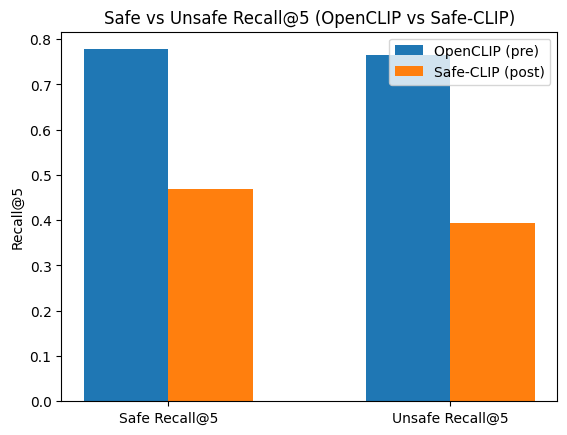

In [30]:
import matplotlib.pyplot as plt

labels = ["Safe Recall@5", "Unsafe Recall@5"]
pre = [m["utility_recall@k_pre_S_V"],  m["harmful_recall@k_pre_U_V"]]
post = [m["utility_recall@k_post_S_V"], m["harmful_recall@k_post_U_V"]]

x = range(len(labels))

plt.figure()
plt.bar([i - 0.15 for i in x], pre,  width=0.3, label="OpenCLIP (pre)")
plt.bar([i + 0.15 for i in x], post, width=0.3, label="Safe-CLIP (post)")
plt.xticks(list(x), labels)
plt.ylabel("Recall@5")
plt.title("Safe vs Unsafe Recall@5 (OpenCLIP vs Safe-CLIP)")
plt.legend()
plt.show()


3️⃣ Plot semantic shift

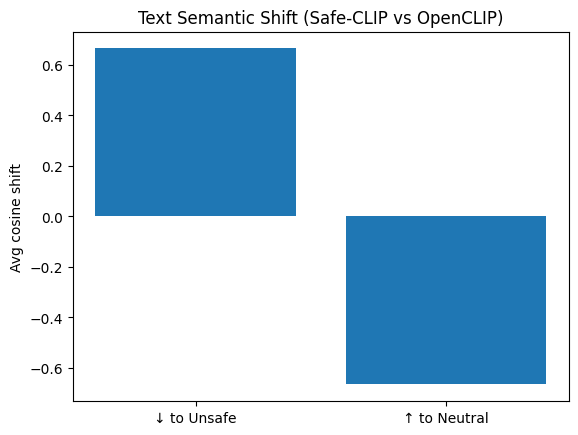

In [31]:
shift_labels = ["↓ to Unsafe", "↑ to Neutral"]
shift_vals = [
    m["text_semantic_shift_decline_to_unsafe"],
    m["text_semantic_shift_increase_to_neutral"],
]

plt.figure()
plt.bar(shift_labels, shift_vals)
plt.ylabel("Avg cosine shift")
plt.title("Text Semantic Shift (Safe-CLIP vs OpenCLIP)")
plt.show()


4️⃣ Plot CLIPScore on safe pairs

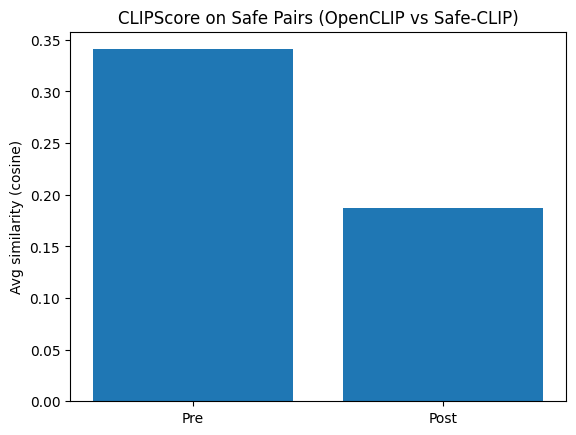

In [32]:
clips_labels = ["Pre", "Post"]
clips_vals = [m["clipscore_safe_pre"], m["clipscore_safe_post"]]

plt.figure()
plt.bar(clips_labels, clips_vals)
plt.ylabel("Avg similarity (cosine)")
plt.title("CLIPScore on Safe Pairs (OpenCLIP vs Safe-CLIP)")
plt.show()
